In [1]:
import warnings
from tqdm import tqdm
from typing import List

from sklearn.utils.validation import check_is_fitted
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import KFold
import shap
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import catboost as catb
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel
from sklearn.model_selection import TimeSeriesSplit
import missingno as msno

from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score
warnings.simplefilter("ignore")
%matplotlib inline

In [326]:
PATH = 'H:PyProgects/gb_Competitive_Data_Analysis/'
train = pd.read_csv(PATH + "train.csv")
test = pd.read_csv(PATH + "test.csv")
payments = pd.read_csv(PATH + "payments.csv")
client_profile = pd.read_csv(PATH + "client_profile.csv")
bki = pd.read_csv(PATH + "bki.csv")
applications_history = pd.read_csv(PATH + "applications_history.csv")

print("data.shape = {} rows, {} cols".format(*train.shape))
train.head(n=2)

data.shape = 110093 rows, 3 cols


,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE
0,123687442,0,Cash
1,123597908,1,Cash


In [122]:
train['APPLICATION_NUMBER']

0         123687442
1         123597908
2         123526683
3         123710391
4         123590329
            ...    
110088    123458312
110089    123672463
110090    123723001
110091    123554358
110092    123676265
Name: APPLICATION_NUMBER, Length: 110093, dtype: int64

In [3]:
payments.head(2)

,PREV_APPLICATION_NUMBER,APPLICATION_NUMBER,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,49011181,123664960,1.0,5,1002.0,1015.0,12156.615,12156.615
1,48683432,123497205,1.0,13,442.0,432.0,18392.535,10047.645


In [4]:
bki.head(2)

,APPLICATION_NUMBER,BUREAU_ID,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,123538884,5223613,Active,currency 1,718.0,0,377.0,NaN,19386.81,0,675000.00,320265.495,0.0,0.0,Consumer credit,39.0,NaN
1,123436670,6207544,Closed,currency 1,696.0,0,511.0,511.0,0.00,0,93111.66,0.000,0.0,0.0,Consumer credit,505.0,NaN


In [6]:
applications_history.head(2)

,PREV_APPLICATION_NUMBER,APPLICATION_NUMBER,NAME_CONTRACT_TYPE,AMOUNT_ANNUITY,AMT_APPLICATION,AMOUNT_CREDIT,AMOUNT_PAYMENT,AMOUNT_GOODS_PAYMENT,NAME_CONTRACT_STATUS,DAYS_DECISION,...,NAME_PRODUCT_TYPE,SELLERPLACE_AREA,CNT_PAYMENT,NAME_YIELD_GROUP,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,49298709,123595216,NaN,1730.430,17145.0,17145.0,0.0,17145.0,Approved,73,...,XNA,35,12.0,middle,365243.0,42.0,300.0,42.0,37.0,0.0
1,50070639,123431468,Cash,25188.615,607500.0,679671.0,NaN,607500.0,Approved,164,...,x-sell,-1,36.0,low_action,365243.0,134.0,916.0,365243.0,365243.0,1.0


In [7]:
applications_history.shape

(1670214, 26)

In [12]:
applications_history.describe()

,PREV_APPLICATION_NUMBER,APPLICATION_NUMBER,AMOUNT_ANNUITY,AMT_APPLICATION,AMOUNT_CREDIT,AMOUNT_PAYMENT,AMOUNT_GOODS_PAYMENT,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
count,1.670214e+06,1.670214e+06,1.297979e+06,1.670214e+06,1.670213e+06,7.743700e+05,1.284699e+06,1.670214e+06,1.670214e+06,1.297984e+06,997149.000000,997149.000000,997149.000000,997149.000000,997149.000000,997149.000000
mean,4.919130e+07,1.236017e+08,1.595512e+04,1.752339e+05,1.961140e+05,6.697402e+03,2.278473e+05,8.806797e+02,3.139511e+02,1.605408e+01,342340.056543,15949.224065,35163.363265,78152.730207,83505.775017,0.332570
std,5.325980e+05,1.028148e+05,1.478214e+04,2.927798e+05,3.185746e+05,2.092150e+04,3.153966e+05,7.790997e+02,7.127443e+03,1.456729e+01,88413.495220,72007.270877,106405.950190,148833.342466,152484.418802,0.471134
min,4.826822e+07,1.234233e+08,0.000000e+00,0.000000e+00,0.000000e+00,-9.000000e-01,0.000000e+00,1.000000e+00,-1.000000e+00,0.000000e+00,2.000000,2.000000,0.000000,2.000000,2.000000,0.000000
25%,4.873007e+07,1.235127e+08,6.321780e+03,1.872000e+04,2.416050e+04,0.000000e+00,5.084100e+04,2.800000e+02,-1.000000e+00,6.000000e+00,365243.000000,475.000000,257.000000,455.000000,447.000000,0.000000
50%,4.919132e+07,1.236021e+08,1.125000e+04,7.104600e+04,8.054100e+04,1.638000e+03,1.123200e+05,5.810000e+02,3.000000e+00,1.200000e+01,365243.000000,921.000000,741.000000,1155.000000,1171.000000,0.000000
75%,4.965249e+07,1.236909e+08,2.065842e+04,1.803600e+05,2.164185e+05,7.740000e+03,2.340000e+05,1.300000e+03,8.200000e+01,2.400000e+01,365243.000000,1825.000000,1735.000000,2418.000000,2501.000000,1.000000
max,5.011360e+07,1.237796e+08,4.180581e+05,6.905160e+06,6.905160e+06,3.060045e+06,6.905160e+06,2.922000e+03,4.000000e+06,8.400000e+01,365243.000000,365243.000000,365243.000000,365243.000000,365243.000000,1.000000


In [14]:
bki.describe()

,APPLICATION_NUMBER,BUREAU_ID,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
count,9.452340e+05,9.452340e+05,945234.000000,945234.000000,886797.000000,596274.000000,3.265570e+05,945234.000000,9.452290e+05,8.034830e+05,6.192670e+05,9.452340e+05,945234.000000,2.693300e+05
mean,1.236016e+08,5.974377e+06,1142.218231,0.769791,1819.607174,1018.001196,3.784219e+03,0.006330,3.547738e+05,1.361747e+05,6.267718e+03,3.826128e+01,594.056297,1.646679e+04
std,1.029041e+05,5.330431e+05,795.047305,35.173550,4684.447770,715.013564,2.133823e+05,0.094857,1.078781e+06,6.370282e+05,4.528027e+04,5.156032e+03,721.505604,3.937657e+05
min,1.234233e+08,5.001084e+06,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,-4.705600e+06,-5.864061e+05,0.000000e+00,0.000000,0.000000e+00
25%,1.235122e+08,5.513773e+06,474.000000,0.000000,383.000000,426.000000,0.000000e+00,0.000000,5.121000e+04,0.000000e+00,0.000000e+00,0.000000e+00,33.000000,0.000000e+00
50%,1.236014e+08,5.976502e+06,987.000000,0.000000,863.000000,897.000000,0.000000e+00,0.000000,1.254708e+05,0.000000e+00,0.000000e+00,0.000000e+00,396.000000,0.000000e+00
75%,1.236908e+08,6.435551e+06,1666.000000,0.000000,1504.000000,1489.000000,0.000000e+00,0.000000,3.150000e+05,3.973275e+04,0.000000e+00,0.000000e+00,908.000000,1.350000e+04
max,1.237796e+08,6.942186e+06,2922.000000,2792.000000,42060.000000,42023.000000,1.159872e+08,7.000000,3.960000e+08,6.544140e+07,4.705600e+06,2.387232e+06,41943.000000,1.184534e+08


In [15]:
payments.describe()

,PREV_APPLICATION_NUMBER,APPLICATION_NUMBER,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
count,1.023932e+06,1.023932e+06,1.023932e+06,1.023932e+06,1.023932e+06,1.023729e+06,1.023932e+06,1.023729e+06
mean,4.917253e+07,1.236018e+08,8.569114e-01,1.888052e+01,1.042505e+03,1.051378e+03,1.714263e+04,1.733931e+04
std,5.363093e+05,1.027412e+05,1.053180e+00,2.669996e+01,8.013580e+02,8.009974e+02,5.130650e+04,5.557338e+04
min,4.826822e+07,1.234233e+08,0.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00
25%,4.870325e+07,1.235130e+08,0.000000e+00,4.000000e+00,3.610000e+02,3.700000e+02,4.217445e+03,3.386205e+03
50%,4.916602e+07,1.236020e+08,1.000000e+00,8.000000e+00,8.170000e+02,8.260000e+02,8.878500e+03,8.115390e+03
75%,4.963797e+07,1.236910e+08,1.000000e+00,1.900000e+01,1.655000e+03,1.664000e+03,1.671229e+04,1.611140e+04
max,5.011171e+07,1.237796e+08,1.780000e+02,2.750000e+02,2.922000e+03,3.054000e+03,2.860377e+06,2.860377e+06


In [8]:
bki.shape

(945234, 17)

In [9]:
payments.shape

(1023932, 8)

In [10]:
applications_history['NAME_PRODUCT_TYPE'].value_counts()

XNA        1063666
x-sell      456287
walk-in     150261
Name: NAME_PRODUCT_TYPE, dtype: int64

In [11]:
applications_history['NAME_CONTRACT_STATUS'].value_counts()

Approved        1036781
Canceled         316319
Refused          290678
Unused offer      26436
Name: NAME_CONTRACT_STATUS, dtype: int64

In [16]:
numerical_features_applications_history = applications_history.select_dtypes(include=[np.number])
print(f"count of numeric_features {numerical_features_applications_history.shape[1]}")

numerical_features_applications_history.columns

count of numeric_features 16


Index(['PREV_APPLICATION_NUMBER', 'APPLICATION_NUMBER', 'AMOUNT_ANNUITY',
       'AMT_APPLICATION', 'AMOUNT_CREDIT', 'AMOUNT_PAYMENT',
       'AMOUNT_GOODS_PAYMENT', 'DAYS_DECISION', 'SELLERPLACE_AREA',
       'CNT_PAYMENT', 'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE',
       'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION',
       'NFLAG_INSURED_ON_APPROVAL'],
      dtype='object')

In [17]:
numerical_features_bki = bki.select_dtypes(include=[np.number])
print(f"count of numeric_features {numerical_features_bki.shape[1]}")

numerical_features_bki.columns

count of numeric_features 14


Index(['APPLICATION_NUMBER', 'BUREAU_ID', 'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE',
       'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE',
       'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT',
       'AMT_CREDIT_SUM_LIMIT', 'AMT_CREDIT_SUM_OVERDUE', 'DAYS_CREDIT_UPDATE',
       'AMT_ANNUITY'],
      dtype='object')

In [18]:
numerical_features_payments = payments.select_dtypes(include=[np.number])
print(f"count of numeric_features {numerical_features_payments.shape[1]}")

numerical_features_payments.columns

count of numeric_features 8


Index(['PREV_APPLICATION_NUMBER', 'APPLICATION_NUMBER',
       'NUM_INSTALMENT_VERSION', 'NUM_INSTALMENT_NUMBER', 'DAYS_INSTALMENT',
       'DAYS_ENTRY_PAYMENT', 'AMT_INSTALMENT', 'AMT_PAYMENT'],
      dtype='object')

In [ ]:
discrete_feature = [
    feature for feature in numerical_features
    if len(train[feature].unique())<25 and feature not in year_feature+["Id"]
]

print(f"Discrete Variables Count: {len(discrete_feature)}")

In [70]:
class DataSet:
    
    def __init__(self, path):
        self.data = pd.read_csv(path)
        self.numerical_features = self.data.select_dtypes(include=[np.number])
        self.discrete_feature = [
                                    feature for feature in self.numerical_features
                                    if len(self.data[feature].unique())<25
        ]
        self.continuous_feature = [
                                    feature for feature in self.numerical_features
                                    if feature not in self.discrete_feature
        ]
        
        self.categorical_features = self.data.select_dtypes(include=[np.object])
        self.correlation = self.numerical_features.corr()

        
    def describe(self):
        print(self.data.shape)
        print(self.data.describe())
        print(f"count of numeric_features {self.numerical_features.shape[1]}")
        print(self.numerical_features.columns)
        print(f"Discrete Variables Count: {len(self.discrete_feature)}")
        print(self.discrete_feature)
        print(f"Continuous Variables Count: {len(self.continuous_feature)}")
        print(self.continuous_feature)
        print(f"Categorical Feature Count {self.categorical_features.shape[1]}")
        msno.matrix(self.data)
        
    def correlation(self):
        fig, axes = plt.subplots(figsize = (14,12))
        plt.title("Correlation of Numeric Features", y=1, size=16)
        sns.heatmap(self.correlation, square=True, vmax=0.8, cmap="viridis")

In [328]:
payments = DataSet(PATH + "payments.csv")

In [321]:
payments.data

,PREV_APPLICATION_NUMBER,APPLICATION_NUMBER,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,49011181,123664960,1.0,5,1002.0,1015.0,12156.615,12156.615
1,48683432,123497205,1.0,13,442.0,432.0,18392.535,10047.645
2,48652024,123749925,1.0,10,8.0,23.0,5499.945,5499.945
3,48398897,123550846,0.0,82,398.0,398.0,7082.145,7082.145
4,49867197,123562174,0.0,63,1359.0,1359.0,156.735,156.735
...,...,...,...,...,...,...,...,...
1023927,50029793,123728077,0.0,123,993.0,993.0,2700.000,2700.000
1023928,48418780,123568892,0.0,73,529.0,529.0,232.335,232.335
1023929,49942303,123494001,2.0,24,389.0,393.0,23284.485,23284.485
1023930,50081462,123609565,0.0,4,2671.0,2671.0,9000.000,9000.000


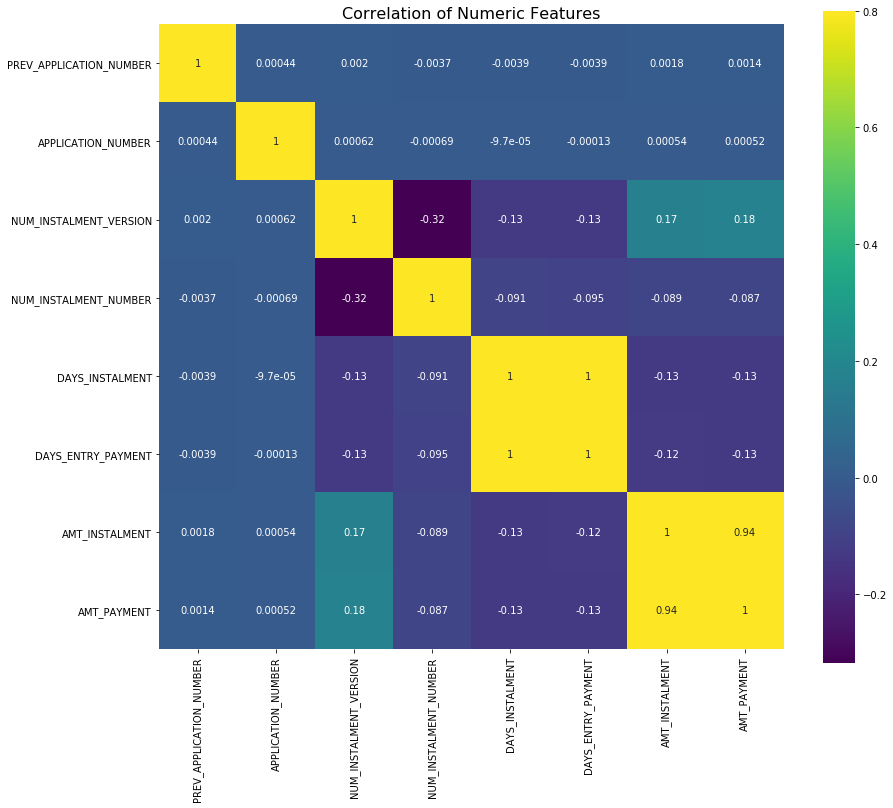

In [78]:
def pll_corr():
    fig, axes = plt.subplots(figsize = (14,12))
    plt.title("Correlation of Numeric Features", y=1, size=16)
    sns.heatmap(payments.correlation, square=True, vmax=0.8, annot=True, cmap="viridis")
    
pll_corr()


In [323]:
payments.data.head(5)

,PREV_APPLICATION_NUMBER,APPLICATION_NUMBER,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,49011181,123664960,1.0,5,1002.0,1015.0,12156.615,12156.615
1,48683432,123497205,1.0,13,442.0,432.0,18392.535,10047.645
2,48652024,123749925,1.0,10,8.0,23.0,5499.945,5499.945
3,48398897,123550846,0.0,82,398.0,398.0,7082.145,7082.145
4,49867197,123562174,0.0,63,1359.0,1359.0,156.735,156.735


In [325]:
train

,TARGET,NAME_CONTRACT_TYPE
APPLICATION_NUMBER,,
123687442,0,Cash
123597908,1,Cash
123526683,0,Cash
123710391,1,Cash
123590329,1,Cash
...,...,...
123458312,0,Cash
123672463,0,Cash
123723001,0,Cash


In [329]:
payments.data = payments.data.loc[(payments.data['PREV_APPLICATION_NUMBER'].isin(train['APPLICATION_NUMBER'])) | (payments.data['APPLICATION_NUMBER'].isin(test['APPLICATION_NUMBER']))]

In [330]:
payments.data['DIST_ATM_PAYMENT'] =  payments.data['AMT_PAYMENT'] - payments.data['AMT_INSTALMENT']
payments.data['VAR_ATM_PAYMENT'] =  payments.data['AMT_PAYMENT'] / payments.data['AMT_INSTALMENT']
payments.data.drop('AMT_INSTALMENT', axis=1, inplace=True)

In [331]:
payments.data['DIST_ENTRY_PAYMENT'] =  payments.data['DAYS_ENTRY_PAYMENT'] - payments.data['DAYS_INSTALMENT']
payments.data['VAR_ENTRY_PAYMENT'] =  payments.data['DAYS_INSTALMENT'] / payments.data['DAYS_ENTRY_PAYMENT']
payments.data.drop('DAYS_INSTALMENT', axis=1, inplace=True)

In [332]:
import time
import numpy as np
import pandas as pd
import catboost as cb
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gmean, rankdata

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder
from bayes_opt import BayesianOptimization

pd.set_option("display.max_columns", 30)

In [333]:
def cross_validation(model, X, y, cv, categorical = []):
    """
    Кросс-валидация для модели catbooost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    estimators, folds_scores = [], []
    oof_preds = np.zeros(X.shape[0])

    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")
    if categorical:
        X[categorical] = X[categorical].astype(str)

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):

        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y.loc[train_idx], y.loc[valid_idx]

        model.fit(
            x_train, y_train, categorical,
            eval_set=[(x_train, y_train), (x_valid, y_valid)]
        )
        oof_preds[valid_idx] = model.predict_proba(x_valid)[:, 1]
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        folds_scores.append(round(score, 5))
        estimators.append(model)

    print(f"Score by each fold: {folds_scores}")
    print("="*65)
    return estimators, oof_preds


In [359]:
def get_pivot(data, x, col, split=0.2):
    x.sort_values(by=col, ascending=False)
    grp = x.groupby('APPLICATION_NUMBER')
    x['ID_Count'] = grp['NUM_INSTALMENT_NUMBER'].cumcount() + 1
    df_out = x.pivot('APPLICATION_NUMBER', 'ID_Count', col).add_prefix(col)
    value_var_e_p = df_out[df_out.columns[df_out.describe().iloc[0]>df_out.shape[0]*split]]
    hystory_pay = data[['APPLICATION_NUMBER', 'NAME_CONTRACT_TYPE', 'TARGET']].merge(value_var_e_p, on='APPLICATION_NUMBER', how='left')
    hystory_pay = hystory_pay.reset_index(drop=True)
    return hystory_pay



In [360]:
hystory_pay

,PREV_APPLICATION_NUMBER,APPLICATION_NUMBER,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_ENTRY_PAYMENT,AMT_PAYMENT,DIST_ATM_PAYMENT,VAR_ATM_PAYMENT,DIST_ENTRY_PAYMENT,VAR_ENTRY_PAYMENT,ID_Count
1,48683432,123497205,1.0,13,432.0,10047.645,-8344.89,0.546289,-10.0,1.023148,1
3,48398897,123550846,0.0,82,398.0,7082.145,0.00,1.000000,0.0,1.000000,1
4,49867197,123562174,0.0,63,1359.0,156.735,0.00,1.000000,0.0,1.000000,1
5,48585558,123653945,0.0,49,946.0,3375.000,0.00,1.000000,11.0,0.988372,1
6,49988618,123577024,1.0,2,703.0,13041.630,0.00,1.000000,11.0,0.984353,1
...,...,...,...,...,...,...,...,...,...,...,...
1023920,48536466,123701595,0.0,86,396.0,372.015,0.00,1.000000,0.0,1.000000,8
1023925,49936735,123709947,0.0,27,289.0,193.680,0.00,1.000000,0.0,1.000000,6
1023926,49162007,123561981,2.0,3,131.0,15782.400,12358.80,4.609884,1.0,0.992366,3
1023929,49942303,123494001,2.0,24,393.0,23284.485,0.00,1.000000,4.0,0.989822,14


In [365]:
hystory_pay = pd.DataFrame()
for col in ['DAYS_ENTRY_PAYMENT', 'AMT_PAYMENT', 'DIST_ATM_PAYMENT', 'VAR_ATM_PAYMENT', 'DIST_ENTRY_PAYMENT', 'VAR_ENTRY_PAYMENT']:
    hystory_pay = get_pivot(train, payments.data, col, 0.2)


In [367]:
hystory_pay = get_pivot(train, payments.data, 'DAYS_ENTRY_PAYMENT', 0.2)

In [368]:
hystory_pay

,APPLICATION_NUMBER,NAME_CONTRACT_TYPE,TARGET,col1,col2,col3,col4,col5,col6
0,123687442,Cash,0,NaN,NaN,NaN,NaN,NaN,NaN
1,123597908,Cash,1,NaN,NaN,NaN,NaN,NaN,NaN
2,123526683,Cash,0,NaN,NaN,NaN,NaN,NaN,NaN
3,123710391,Cash,1,NaN,NaN,NaN,NaN,NaN,NaN
4,123590329,Cash,1,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
110088,123458312,Cash,0,NaN,NaN,NaN,NaN,NaN,NaN
110089,123672463,Cash,0,NaN,NaN,NaN,NaN,NaN,NaN
110090,123723001,Cash,0,NaN,NaN,NaN,NaN,NaN,NaN
110091,123554358,Cash,0,NaN,NaN,NaN,NaN,NaN,NaN


In [311]:
cb_params = {
    "n_estimators": 2000,
    "learning_rate": 0.01,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 20,
    "verbose": 10,
    "max_depth": 6,
    "l2_leaf_reg": 10,
    "early_stopping_rounds": 50,
    "thread_count": 6,
    "random_seed": 1196
}

cv = KFold(n_splits=5, random_state=1234123, shuffle=True)

estimators_catboost, oof_preds_catboost = cross_validation(
    model=cb.CatBoostClassifier(**cb_params), X=hystory_pay.drop(['TARGET', 'NAME_CONTRACT_TYPE'], axis=1), y=hystory_pay['TARGET'], cv=cv, categorical=[]
)

Wed Dec 23 16:35:43 2020, Cross-Validation, 110093 rows, 6 cols
0:	test: 0.5131486	test1: 0.5019962	best: 0.5019962 (0)	total: 25.3ms	remaining: 50.6s
10:	test: 0.5337748	test1: 0.5066946	best: 0.5083990 (8)	total: 266ms	remaining: 48.2s
20:	test: 0.5413546	test1: 0.5078288	best: 0.5087854 (14)	total: 511ms	remaining: 48.2s
30:	test: 0.5447208	test1: 0.5050095	best: 0.5087854 (14)	total: 755ms	remaining: 48s
40:	test: 0.5482592	test1: 0.5065442	best: 0.5087854 (14)	total: 995ms	remaining: 47.5s
50:	test: 0.5501835	test1: 0.5047005	best: 0.5087854 (14)	total: 1.24s	remaining: 47.5s
60:	test: 0.5526747	test1: 0.5045684	best: 0.5087854 (14)	total: 1.48s	remaining: 47s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5087854374
bestIteration = 14

Shrink model to first 15 iterations.
Fold 1, Valid score = 0.50878
0:	test: 0.5147253	test1: 0.4966790	best: 0.4966790 (0)	total: 28.9ms	remaining: 57.8s
10:	test: 0.5314023	test1: 0.4958421	best: 0.5004615 (3)	total: 265ms	rem

In [315]:
payments.data

,PREV_APPLICATION_NUMBER,APPLICATION_NUMBER,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_ENTRY_PAYMENT,AMT_PAYMENT,DIST_ATM_PAYMENT,VAR_ATM_PAYMENT,DIST_ENTRY_PAYMENT,VAR_ENTRY_PAYMENT,ID_Count
927588,49167818,123537244,1.0,1,350.0,45587.160,0.00,1.000000,17.0,0.951429,1
452479,48686374,123542962,1.0,1,635.0,3840.345,0.00,1.000000,8.0,0.987402,1
684767,48811860,123572307,1.0,1,227.0,9782.865,0.00,1.000000,13.0,0.942731,1
918764,48395020,123654132,1.0,1,494.0,7285.950,0.00,1.000000,10.0,0.979757,1
452494,49479479,123567840,1.0,1,173.0,17824.545,0.00,1.000000,1.0,0.994220,1
...,...,...,...,...,...,...,...,...,...,...,...
271409,49860788,123540699,0.0,245,414.0,218.070,-15981.93,0.013461,17.0,0.958937,16
391102,48864370,123536930,0.0,248,110.0,20250.000,0.00,1.000000,0.0,1.000000,16
218330,49860788,123540699,0.0,253,349.0,2250.000,0.00,1.000000,0.0,1.000000,17
158592,49860788,123540699,0.0,254,313.0,1800.000,-14400.00,0.111111,8.0,0.974441,18


In [ ]:
# 1000
# Shrink model to first 26 iterations.
# Fold 5, Valid score = 0.50153
# Score by each fold: [0.50434, 0.517, 0.5193, 0.5016, 0.50153]


# 2000
# Shrink model to first 7 iterations.
# Fold 5, Valid score = 0.50209
# Score by each fold: [0.50627, 0.50425, 0.51477, 0.50253, 0.50209]

# Shrink model to first 1 iterations.
# Fold 5, Valid score = 0.5058
# Score by each fold: [0.50221, 0.49767, 0.50532, 0.49962, 0.5058

# (by='DIST_ENTRY_PAYMENT', ascending=False)

# Shrink model to first 10 iterations.
# Fold 5, Valid score = 0.5039
# Score by each fold: [0.50878, 0.50046, 0.50483, 0.50621, 0.5039]

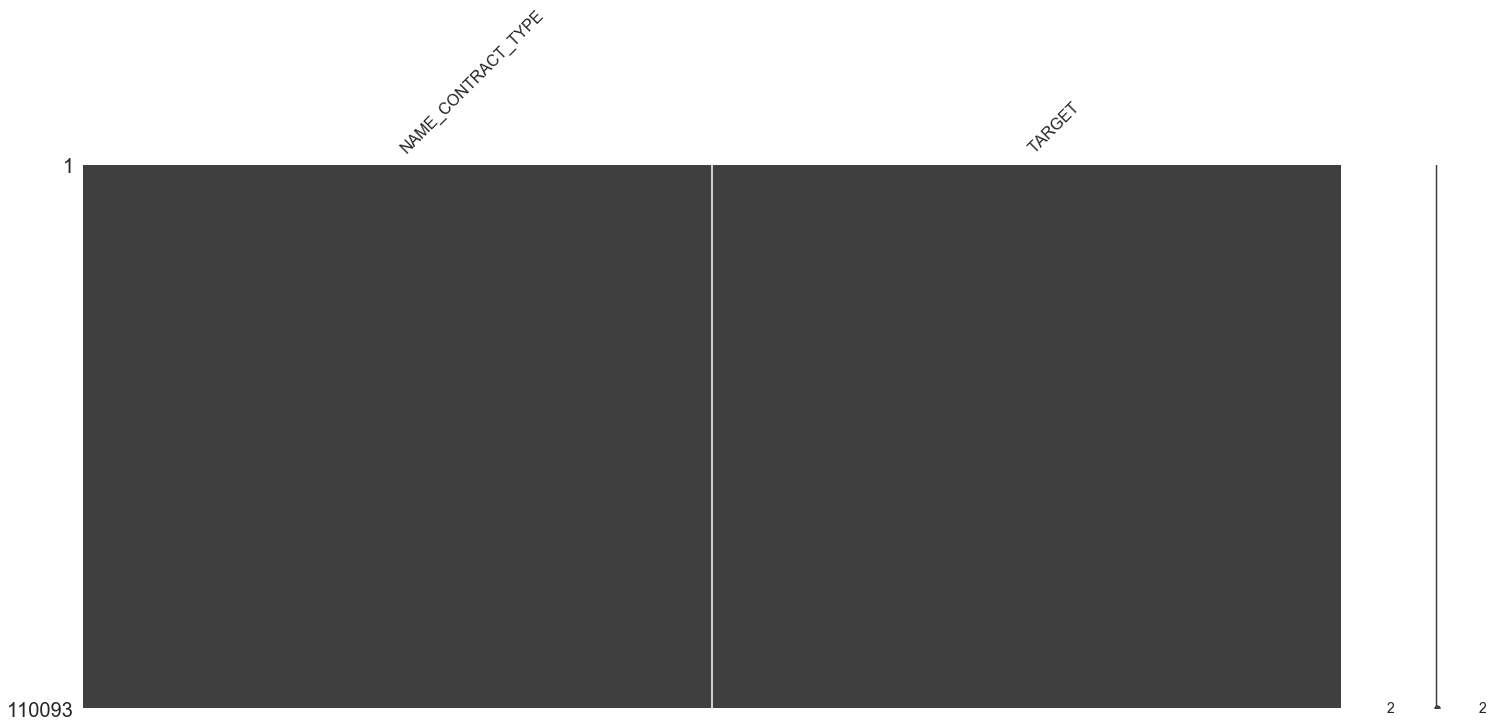

In [273]:
msno.matrix(hystory_pay)

In [223]:
df_out[df_out.columns[df_out.describe().iloc[0]>75000]]

ID_Count,VAR_ENTRY_PAYMENT1,VAR_ENTRY_PAYMENT2,VAR_ENTRY_PAYMENT3,VAR_ENTRY_PAYMENT4
APPLICATION_NUMBER,,,,
123423341,0.946667,0.858586,NaN,NaN
123423344,0.959239,NaN,NaN,NaN
123423345,0.916370,0.986111,NaN,NaN
123423346,0.997026,1.000895,0.987952,0.986711
123423347,0.989189,0.933962,NaN,NaN
...,...,...,...,...
123730845,0.979973,1.000000,0.970423,0.996825
123730846,0.988926,0.961538,0.987520,0.991970
123730847,0.998803,1.015099,0.998027,NaN


In [149]:
pay_history = df_out.iloc[:,0:19].fillna(1)

In [150]:
pay_history

ID_Count,VAR_ENTRY_PAYMENT1,VAR_ENTRY_PAYMENT2,VAR_ENTRY_PAYMENT3,VAR_ENTRY_PAYMENT4,VAR_ENTRY_PAYMENT5,VAR_ENTRY_PAYMENT6,VAR_ENTRY_PAYMENT7,VAR_ENTRY_PAYMENT8,VAR_ENTRY_PAYMENT9,VAR_ENTRY_PAYMENT10,VAR_ENTRY_PAYMENT11,VAR_ENTRY_PAYMENT12,VAR_ENTRY_PAYMENT13,VAR_ENTRY_PAYMENT14,VAR_ENTRY_PAYMENT15,VAR_ENTRY_PAYMENT16,VAR_ENTRY_PAYMENT17,VAR_ENTRY_PAYMENT18,VAR_ENTRY_PAYMENT19
APPLICATION_NUMBER,,,,,,,,,,,,,,,,,,,
123423341,0.946667,0.858586,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
123423344,0.959239,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
123423345,0.916370,0.986111,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
123423346,0.997026,1.000895,0.987952,0.986711,0.999332,0.985240,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
123423347,0.989189,0.933962,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123730845,0.979973,1.000000,0.970423,0.996825,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
123730846,0.988926,0.961538,0.987520,0.991970,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
123730847,0.998803,1.015099,0.998027,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


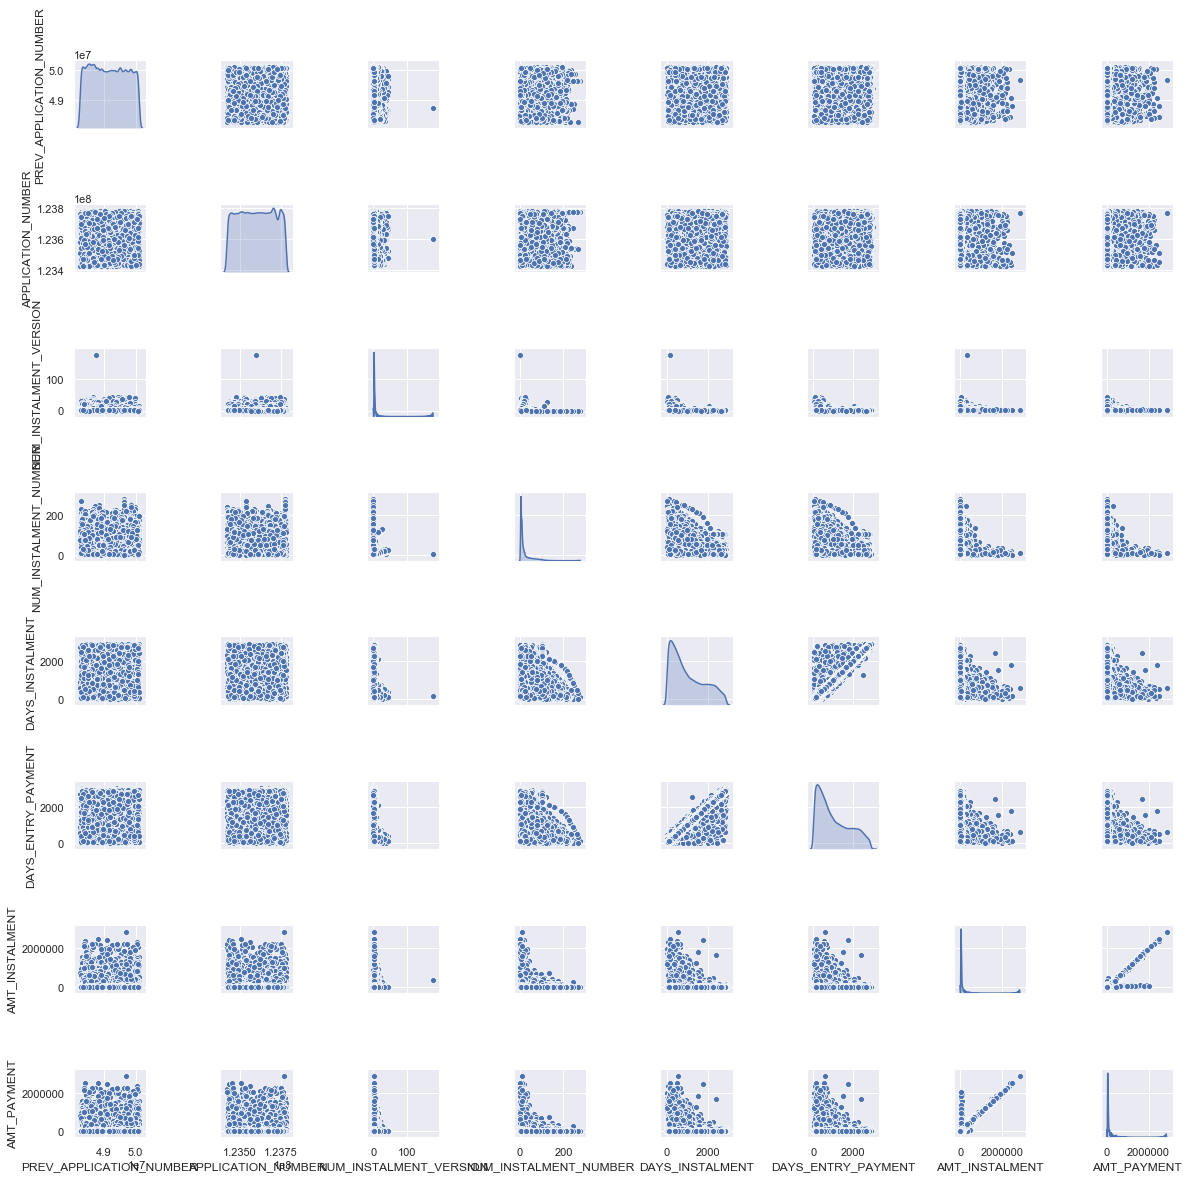

In [81]:
sns.set()


sns.pairplot(payments.numerical_features, size=2, kind="scatter", diag_kind="kde")
plt.show()